In [241]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import sklearn
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [242]:
input_dataframe = pd.read_csv('F:\Lead Scoring Assignment\Leads.csv')
input_dataframe.head(6)

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified
5,2058ef08-2858-443e-a01f-a9237db2f5ce,660680,API,Olark Chat,No,No,0,0.0,0,0.0,Olark Chat Conversation,NaN,NaN,NaN,NaN,NaN,No,No,No,No,No,No,No,No,NaN,NaN,No,No,NaN,NaN,01.High,02.Medium,17.0,15.0,No,No,Modified


In [243]:
input_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

## Data Preparation

Since Prospect ID is a unique ID with which the customer is identified and Lead Number implies a number assigned to each lead procured, we will check whether these are unique and not-null values.

In [244]:
print('Prospect ID: ', sum(input_dataframe.duplicated(subset='Prospect ID')))
print('Lead Number: ', sum(input_dataframe.duplicated(subset='Prospect ID')))

Prospect ID:  0
Lead Number:  0


In [245]:
input_dataframe[['Prospect ID', 'Lead Number']].isnull().sum()

Prospect ID    0
Lead Number    0
dtype: int64

Both are unique and not null which means each row implies a different customer and so these can be dropped.

In [246]:
input_dataframe.drop(['Prospect ID', 'Lead Number'], 1, inplace = True)

### Check missing values

In [247]:
#Many of the categorical variables have a level called 'Select' which needs to be handled because it is as good as a null value as per the Problem Statement.
input_dataframe = input_dataframe.replace('Select', np.nan)

In [248]:
round((100*input_dataframe.isnull().sum()/input_dataframe.shape[0]),2).sort_values(ascending=False)

How did you hear about X Education               78.46
Lead Profile                                     74.19
Lead Quality                                     51.59
Asymmetrique Activity Score                      45.65
Asymmetrique Profile Score                       45.65
Asymmetrique Profile Index                       45.65
Asymmetrique Activity Index                      45.65
City                                             39.71
Specialization                                   36.58
Tags                                             36.29
What matters most to you in choosing a course    29.32
What is your current occupation                  29.11
Country                                          26.63
TotalVisits                                       1.48
Page Views Per Visit                              1.48
Last Activity                                     1.11
Lead Source                                       0.39
Get updates on DM Content                         0.00
Update me 

In [249]:
#Removing variables with more than 30% missing values
columns_to_drop=input_dataframe.loc[:,list(round((100*input_dataframe.isnull().sum()/input_dataframe.shape[0]),2)>30)].columns
columns_to_drop

Index(['Specialization', 'How did you hear about X Education', 'Tags',
       'Lead Quality', 'Lead Profile', 'City', 'Asymmetrique Activity Index',
       'Asymmetrique Profile Index', 'Asymmetrique Activity Score',
       'Asymmetrique Profile Score'],
      dtype='object')

In [250]:
input_dataframe=input_dataframe.drop(columns_to_drop,axis=1)

In [251]:
round((100*input_dataframe.isnull().sum()/input_dataframe.shape[0]),2).sort_values(ascending=False)

What matters most to you in choosing a course    29.32
What is your current occupation                  29.11
Country                                          26.63
TotalVisits                                       1.48
Page Views Per Visit                              1.48
Last Activity                                     1.11
Lead Source                                       0.39
Lead Origin                                       0.00
Newspaper                                         0.00
A free copy of Mastering The Interview            0.00
I agree to pay the amount through cheque          0.00
Get updates on DM Content                         0.00
Update me on Supply Chain Content                 0.00
Receive More Updates About Our Courses            0.00
Through Recommendations                           0.00
Digital Advertisement                             0.00
Search                                            0.00
X Education Forums                                0.00
Newspaper 

#### Imputing missing values

In [252]:
input_dataframe['What matters most to you in choosing a course'].value_counts(normalize=True,dropna=False)

Better Career Prospects      0.706494
NaN                          0.293182
Flexibility & Convenience    0.000216
Other                        0.000108
Name: What matters most to you in choosing a course, dtype: float64

'What matters most to you in choosing a course' seems to be highly skewed with one category 'Better Career Prospects'. Imputing 
 null values with mode would cause the variable to be almost constant within the dataset. So removing the field.

In [253]:
input_dataframe.drop('What matters most to you in choosing a course', axis = 1, inplace = True)

In [254]:
input_dataframe['What is your current occupation'].value_counts(normalize=True,dropna=False)

Unemployed              0.606061
NaN                     0.291126
Working Professional    0.076407
Student                 0.022727
Other                   0.001732
Housewife               0.001082
Businessman             0.000866
Name: What is your current occupation, dtype: float64

In [255]:
#Imputing with mode
input_dataframe['What is your current occupation'] = input_dataframe['What is your current occupation'].replace(np.nan, input_dataframe['What is your current occupation'].mode()[0])

In [256]:
input_dataframe['Country'].value_counts(normalize=True,dropna=False)

India                   0.702597
NaN                     0.266342
United States           0.007468
United Arab Emirates    0.005736
Singapore               0.002597
Saudi Arabia            0.002273
United Kingdom          0.001623
Australia               0.001407
Qatar                   0.001082
Bahrain                 0.000758
Hong Kong               0.000758
Oman                    0.000649
France                  0.000649
unknown                 0.000541
Kuwait                  0.000433
South Africa            0.000433
Canada                  0.000433
Nigeria                 0.000433
Germany                 0.000433
Sweden                  0.000325
Philippines             0.000216
Uganda                  0.000216
Italy                   0.000216
Bangladesh              0.000216
Netherlands             0.000216
Asia/Pacific Region     0.000216
China                   0.000216
Belgium                 0.000216
Ghana                   0.000216
Kenya                   0.000108
Sri Lanka 

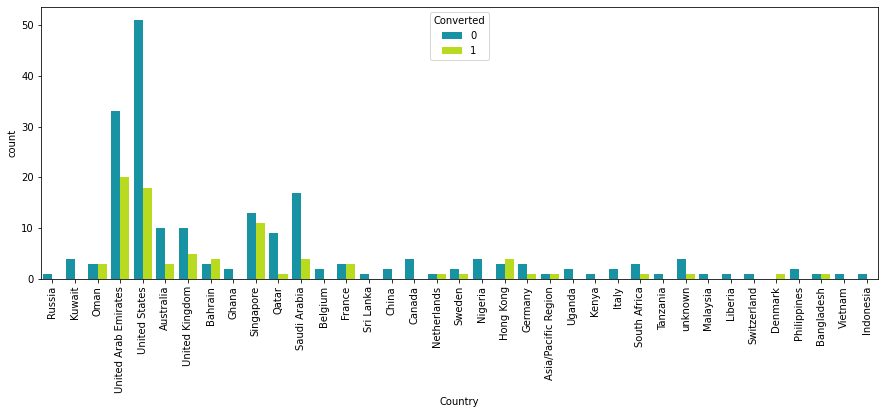

In [257]:
plt.figure(figsize=(15,5))
sns.countplot(input_dataframe[input_dataframe['Country']!='India']['Country'], hue=input_dataframe['Converted'],palette='nipy_spectral')
plt.xticks(rotation = 90)
plt.show()

There seems to be correlation with country where countries like Oman, Hong Kong, France etc seems top have high conversion rate. 

In [258]:
#Imputing with mode
input_dataframe['Country'] = input_dataframe['Country'].replace(np.nan, input_dataframe['Country'].mode()[0])

In [259]:
input_dataframe['TotalVisits'].value_counts(normalize=True,dropna=False)

0.0      0.236905
2.0      0.181818
3.0      0.141342
4.0      0.121212
5.0      0.084740
6.0      0.050433
1.0      0.042749
7.0      0.033442
8.0      0.024242
9.0      0.017749
NaN      0.014827
10.0     0.012338
11.0     0.009307
13.0     0.005195
12.0     0.004870
14.0     0.003896
16.0     0.002273
15.0     0.001948
17.0     0.001732
18.0     0.001623
20.0     0.001299
19.0     0.000974
21.0     0.000649
23.0     0.000649
24.0     0.000541
25.0     0.000541
27.0     0.000541
22.0     0.000325
29.0     0.000216
28.0     0.000216
26.0     0.000216
141.0    0.000108
55.0     0.000108
30.0     0.000108
43.0     0.000108
74.0     0.000108
41.0     0.000108
54.0     0.000108
115.0    0.000108
251.0    0.000108
32.0     0.000108
42.0     0.000108
Name: TotalVisits, dtype: float64

In [260]:
#Imputing with median
input_dataframe['TotalVisits'].fillna(input_dataframe['TotalVisits'].median(), inplace=True)

In [261]:
input_dataframe['Page Views Per Visit'].value_counts(normalize=True,dropna=False)

0.00    0.236905
2.00    0.194264
3.00    0.129437
4.00    0.096970
1.00    0.070455
          ...   
2.56    0.000108
6.33    0.000108
1.64    0.000108
8.21    0.000108
2.08    0.000108
Name: Page Views Per Visit, Length: 115, dtype: float64

In [262]:
#Imputing with median
input_dataframe['Page Views Per Visit'].fillna(input_dataframe['Page Views Per Visit'].median(), inplace=True)

In [263]:
input_dataframe['Last Activity'].value_counts(normalize=True,dropna=False)

Email Opened                    0.371970
SMS Sent                        0.297078
Olark Chat Conversation         0.105303
Page Visited on Website         0.069264
Converted to Lead               0.046320
Email Bounced                   0.035281
Email Link Clicked              0.028896
Form Submitted on Website       0.012554
NaN                             0.011147
Unreachable                     0.010065
Unsubscribed                    0.006602
Had a Phone Conversation        0.003247
Approached upfront              0.000974
View in browser link Clicked    0.000649
Email Received                  0.000216
Email Marked Spam               0.000216
Visited Booth in Tradeshow      0.000108
Resubscribed to emails          0.000108
Name: Last Activity, dtype: float64

In [264]:
#Imputing with mode
input_dataframe['Last Activity'] = input_dataframe['Last Activity'].replace(np.nan, input_dataframe['Last Activity'].mode()[0])

In [265]:
input_dataframe['Lead Source'].value_counts(normalize=True,dropna=False)

Google               0.310390
Direct Traffic       0.275216
Olark Chat           0.189935
Organic Search       0.124892
Reference            0.057792
Welingak Website     0.015368
Referral Sites       0.013528
Facebook             0.005952
NaN                  0.003896
bing                 0.000649
google               0.000541
Click2call           0.000433
Press_Release        0.000216
Social Media         0.000216
Live Chat            0.000216
youtubechannel       0.000108
testone              0.000108
Pay per Click Ads    0.000108
welearnblog_Home     0.000108
WeLearn              0.000108
blog                 0.000108
NC_EDM               0.000108
Name: Lead Source, dtype: float64

In [266]:
#Imputing with mode
input_dataframe['Lead Source'] = input_dataframe['Lead Source'].replace(np.nan, input_dataframe['Lead Source'].mode()[0])

In [267]:
round((100*input_dataframe.isnull().sum()/input_dataframe.shape[0]),2).sort_values(ascending=False)

Lead Origin                                 0.0
Lead Source                                 0.0
A free copy of Mastering The Interview      0.0
I agree to pay the amount through cheque    0.0
Get updates on DM Content                   0.0
Update me on Supply Chain Content           0.0
Receive More Updates About Our Courses      0.0
Through Recommendations                     0.0
Digital Advertisement                       0.0
Newspaper                                   0.0
X Education Forums                          0.0
Newspaper Article                           0.0
Magazine                                    0.0
Search                                      0.0
What is your current occupation             0.0
Country                                     0.0
Last Activity                               0.0
Page Views Per Visit                        0.0
Total Time Spent on Website                 0.0
TotalVisits                                 0.0
Converted                               

In [268]:
#Removing columns with constant values
input_dataframe = input_dataframe[input_dataframe.loc[:, (input_dataframe != input_dataframe.iloc[0]).any()].columns] 

In [269]:
input_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 19 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Lead Origin                             9240 non-null   object 
 1   Lead Source                             9240 non-null   object 
 2   Do Not Email                            9240 non-null   object 
 3   Do Not Call                             9240 non-null   object 
 4   Converted                               9240 non-null   int64  
 5   TotalVisits                             9240 non-null   float64
 6   Total Time Spent on Website             9240 non-null   int64  
 7   Page Views Per Visit                    9240 non-null   float64
 8   Last Activity                           9240 non-null   object 
 9   Country                                 9240 non-null   object 
 10  What is your current occupation         9240 non-null   obje

In [270]:
categorical_columns = input_dataframe.loc[:, input_dataframe.dtypes == 'object'].columns.tolist()
numerical_columns = [d for d in input_dataframe.columns if d not in categorical_columns and d != 'Converted']

In [271]:
for col in categorical_columns:
    print(input_dataframe[col].astype('category').value_counts(normalize=True,dropna=False))
    print('------------------------------------------------------')

Landing Page Submission    0.528788
API                        0.387446
Lead Add Form              0.077706
Lead Import                0.005952
Quick Add Form             0.000108
Name: Lead Origin, dtype: float64
------------------------------------------------------
Google               0.314286
Direct Traffic       0.275216
Olark Chat           0.189935
Organic Search       0.124892
Reference            0.057792
Welingak Website     0.015368
Referral Sites       0.013528
Facebook             0.005952
bing                 0.000649
google               0.000541
Click2call           0.000433
Press_Release        0.000216
Social Media         0.000216
Live Chat            0.000216
WeLearn              0.000108
Pay per Click Ads    0.000108
NC_EDM               0.000108
blog                 0.000108
testone              0.000108
welearnblog_Home     0.000108
youtubechannel       0.000108
Name: Lead Source, dtype: float64
------------------------------------------------------
No     0.920

From the above analysis, columns 'Do Not Call', 'Newspaper Article', 'X Education Forums', 'Search', 'Newspaper', 'Digital Advertisement'and 'Through Recommendations' seems to be near to constant with more than 99% of data points having same category. So removing them.

In [272]:
input_dataframe = input_dataframe.drop(['Do Not Call', 'Newspaper Article',
                                   'X Education Forums', 'Search', 'Newspaper', 'Digital Advertisement', 'Through Recommendations'], axis=1)

### Outlier treatment for Numerical columns

In [273]:
preprocessed_dataframe = input_dataframe.copy(deep=True)

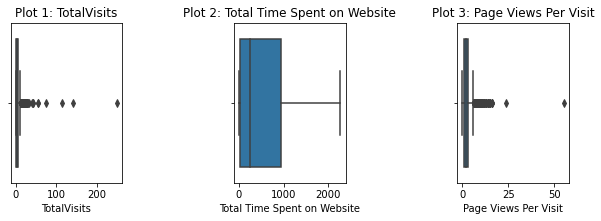

In [274]:
plt.figure(figsize=(10,10))

for index, col in enumerate(numerical_columns):
    plt.subplot(3,3,index+1)
    sns.boxplot(preprocessed_dataframe[col])
    plt.title("Plot "+str(index+1)+": "+col)
plt.subplots_adjust(wspace=1,hspace=0.2)
    
plt.show()

Need to remove the outliers from 'TotalVisits' and 'Page Views Per Visit' as per the box plot.

## Data Analysis

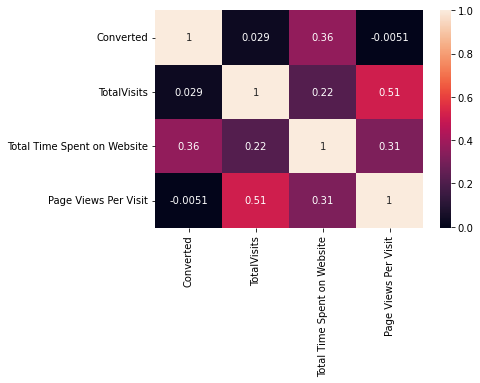

In [275]:
sns.heatmap(preprocessed_dataframe.corr(),annot=True)
plt.show()

Only 'Total Time Spent on Website' has good correlation with Conversion, hence removing 'TotalVisits' and 'Page Views Per Visit'. And since 'Total Time Spent on Website' is not having any outlier, outlier removal is not required.

In [276]:
preprocessed_dataframe.drop(['TotalVisits', 'Page Views Per Visit'], axis = 1, inplace = True)

In [277]:
numerical_columns = ['Total Time Spent on Website']

In [278]:
categorical_columns = preprocessed_dataframe.loc[:, preprocessed_dataframe.dtypes == 'object'].columns.tolist()
categorical_columns

['Lead Origin',
 'Lead Source',
 'Do Not Email',
 'Last Activity',
 'Country',
 'What is your current occupation',
 'A free copy of Mastering The Interview',
 'Last Notable Activity']

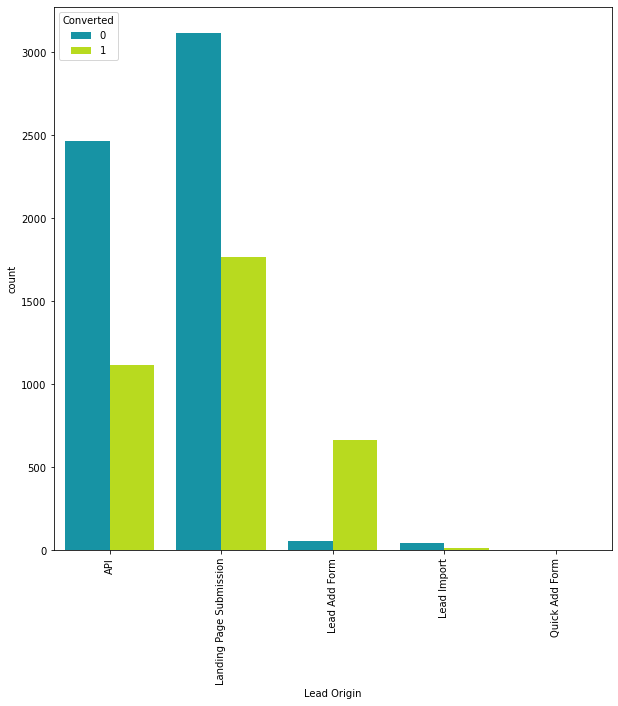

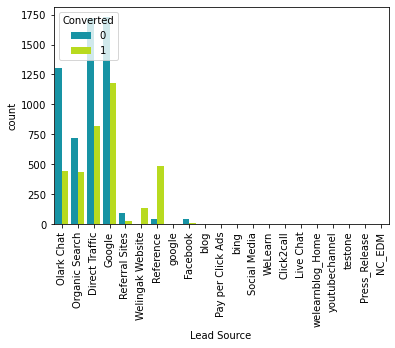

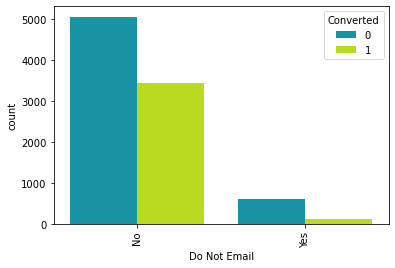

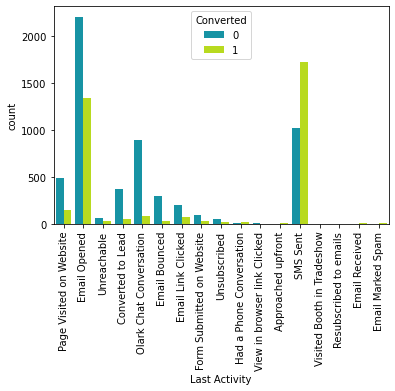

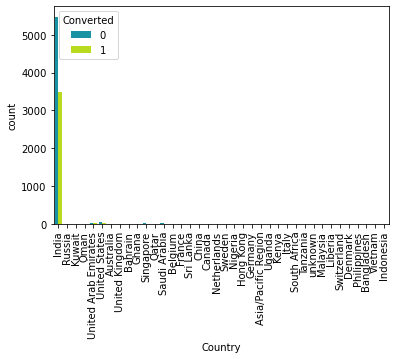

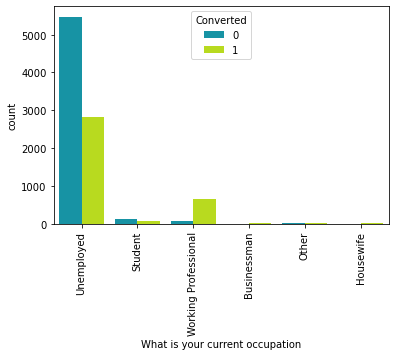

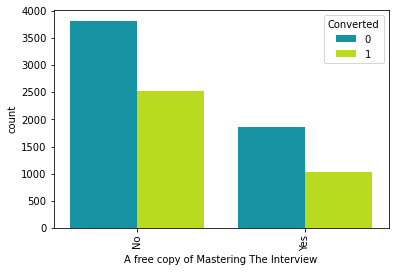

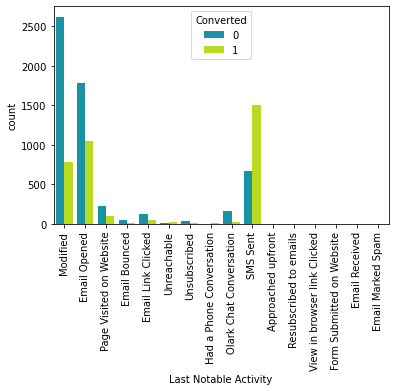

In [279]:
plt.figure(figsize=(10,10))
for col in categorical_columns:
    sns.countplot(preprocessed_dataframe[col], hue=preprocessed_dataframe['Converted'],palette='nipy_spectral')
    plt.xticks(rotation = 90)
    plt.show()

In [280]:
for col in categorical_columns:
    print('\n\n'+col+'\n')
    print('Segment ratio of 0:1')
    print(preprocessed_dataframe[preprocessed_dataframe['Converted']==0][col].value_counts()/ preprocessed_dataframe[preprocessed_dataframe['Converted']==1][col].value_counts())
    



Lead Origin

Segment ratio of 0:1
API                        2.210762
Landing Page Submission    1.763575
Lead Add Form              0.081325
Lead Import                3.230769
Quick Add Form                  NaN
Name: Lead Origin, dtype: float64


Lead Source

Segment ratio of 0:1
Click2call           0.333333
Direct Traffic       2.108802
Facebook             3.230769
Google               1.469388
Live Chat                 NaN
NC_EDM                    NaN
Olark Chat           2.917411
Organic Search       1.646789
Pay per Click Ads         NaN
Press_Release             NaN
Reference            0.089796
Referral Sites       3.032258
Social Media         1.000000
WeLearn                   NaN
Welingak Website     0.014286
bing                 5.000000
blog                      NaN
google                    NaN
testone                   NaN
welearnblog_Home          NaN
youtubechannel            NaN
Name: Lead Source, dtype: float64


Do Not Email

Segment ratio of 0:1
No     1.4705

1. API and Landing Page submission brings most of the leads whereas the conversion rate is higher for Lead Add Form.
2. Lead Import and Quick Add Form brings very few leads and Quick Add Form is having a zero conversion rate.
3. In lead source, Direct Traffic and Olark Chat brings in huge number of leads but suffers very low conversion whereas Google has good lead inputs and decent conversion.
4. Reference shows the highest conversion rate.
5. In Last Activity, Had a Phone Conversation and SMS sent seems to generate hot leads having good conversion rate.
6. Unemployed people seems to be making up for most of the leads but with low conversion of about half. 
7. Businessman and Working Professional contribute for higher conversions. 
8. Housewives are having less lead generation percentage, but the generated leads tend to be converted.

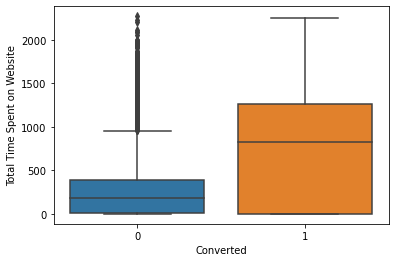

In [281]:
sns.boxplot(x=preprocessed_dataframe.Converted, y=preprocessed_dataframe['Total Time Spent on Website'])
plt.show()

Leads spending more time in website has higher probability to be converted.

### Categorical encoding

In [282]:
dummy_df = pd.DataFrame()
for col in categorical_columns:
    dummy_df = pd.concat([dummy_df, pd.get_dummies(preprocessed_dataframe[col], drop_first = True, prefix = col)], axis=1)

In [283]:
preprocessed_dataframe.drop(columns=categorical_columns,axis=1,inplace =True)

In [284]:
preprocessed_dataframe = pd.concat([preprocessed_dataframe, dummy_df], axis = 1)

### Split and normalization

In [285]:
label = 'Converted'

In [286]:
train_df, test_df = train_test_split(preprocessed_dataframe, train_size = 0.70, test_size = 0.30, random_state = 200)

In [287]:
scaler = StandardScaler()

In [288]:
train_df[numerical_columns] = scaler.fit_transform(train_df[numerical_columns])

## Model Building

In [289]:
## First split independent and dependent variables
feature_list = train_df.columns.tolist()
feature_list.remove(label)
feature_train_df = train_df[feature_list]
label_train_df = train_df[[label]]

In [290]:
logreg=LogisticRegression()
rfe=RFE(logreg,20).fit(feature_train_df,label_train_df)
#list(zip(feature_train_df.columns, rfe.support_, rfe.ranking_))

In [291]:
rfe_feature_list=list(feature_train_df.columns[rfe.support_])
rfe_feature_list

['Total Time Spent on Website',
 'Lead Origin_Lead Add Form',
 'Lead Source_Olark Chat',
 'Lead Source_Welingak Website',
 'Do Not Email_Yes',
 'Last Activity_Converted to Lead',
 'Last Activity_Email Bounced',
 'Last Activity_Olark Chat Conversation',
 'Last Activity_Page Visited on Website',
 'Country_Italy',
 'Country_Nigeria',
 'What is your current occupation_Housewife',
 'What is your current occupation_Student',
 'What is your current occupation_Unemployed',
 'What is your current occupation_Working Professional',
 'Last Notable Activity_Email Link Clicked',
 'Last Notable Activity_Email Opened',
 'Last Notable Activity_Had a Phone Conversation',
 'Last Notable Activity_Modified',
 'Last Notable Activity_Olark Chat Conversation']

In [292]:
#function to calculate VIF
def compute_vif(dataframe_to_check):
    vif_data = pd.DataFrame()
    vif_data['variable'] = dataframe_to_check.columns
    vif_data['vif'] = [variance_inflation_factor(dataframe_to_check.values,
                        d) for d in range(dataframe_to_check.shape[1])]
    return vif_data

In [293]:
feature_train_df_sm = sm.add_constant(feature_train_df[rfe_feature_list])
log_model = sm.GLM(label_train_df,feature_train_df_sm,family=sm.families.Binomial())
log_model = log_model.fit()
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6447
Model Family:                Binomial   Df Model:                           20
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2664.1
Date:                Fri, 12 Apr 2024   Deviance:                       5328.2
Time:                        11:54:46   Pearson chi2:                 7.54e+03
No. Iterations:                    23   Pseudo R-squ. (CS):             0.3993
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    1.0995      0.635      1.732      0.083      -0.145       2.344
Total Time Spent on Website                              1.1576      0.041     28.429      0.000       1.078       1.237
Lead Origin_Lead Add Form                                3.7369      0.200     18.721      0.000       3.346       4.128
Lead Source_Olark Chat                                   1.3066      0.103     12.654      0.000       1.104       1.509
Lead Source_Welingak Website                            22.5732   1.29e+04      0.002      0.999   -2.53e+04    2.53e+04
Do Not Email_Yes                                        -1.2959      0.191     -6.797      0.000      -1.670      -0.922
Last Activity_Converted to Lead                         -0.9850      0.218     -4.521      0.000      -1.412      -0.558
Last Activity_Email Bounced                             -1.0622      0.341     -3.111      0.002      -1.731      -0.393
Last Activity_Olark Chat Conversation                   -1.3986      0.185     -7.546      0.000      -1.762      -1.035
Last Activity_Page Visited on Website                   -1.2549      0.157     -8.009      0.000      -1.562      -0.948
Country_Italy                                          -26.0181    7.4e+04     -0.000      1.000   -1.45e+05    1.45e+05
Country_Nigeria                                        -24.1643   6.37e+04     -0.000      1.000   -1.25e+05    1.25e+05
What is your current occupation_Housewife               24.0149   4.19e+04      0.001      1.000    -8.2e+04    8.21e+04
What is your current occupation_Student                 -0.6375      0.666     -0.957      0.338      -1.942       0.667
What is your current occupation_Unemployed              -1.0347      0.631     -1.640      0.101      -2.271       0.202
What is your current occupation_Working Professional     1.8511      0.658      2.813      0.005       0.561       3.141
Last Notable Activity_Email Link Clicked                -1.8025      0.250     -7.196      0.000      -2.293      -1.312
Last Notable Activity_Email Opened                      -1.3327      0.087    -15.356      0.000      -1.503      -1.163
Last Notable Activity_Had a Phone Conversation           2.1357      1.094      1.953      0.051      -0.008       4.279
Last Notable Activity_Modified                          -1.4982      0.098    -15.250      0.000      -1.691      -1.306
Last Notable Activity_Olark Chat Conversation           -1.5230      0.381     -4.000      0.000      -2.269      -0.777
========================================================================================================================
"""

Removing 'Lead Source_Welingak Website', 'Country_Italy', 'Country_Nigeria', 'What is your current occupation_Student', 'What is your current occupation_Housewife', 'What is your current occupation_Unemployed', 'Last Notable Activity_Had a Phone Conversation' because of high p-value.

In [294]:
rfe_feature_list = [d for d in rfe_feature_list if d not in ['Lead Source_Welingak Website', 'Country_Italy',
        'Country_Nigeria', 'What is your current occupation_Student',
'What is your current occupation_Housewife', 'What is your current occupation_Unemployed',
                                          'Last Notable Activity_Had a Phone Conversation']]

In [295]:
feature_train_df_sm = sm.add_constant(feature_train_df[rfe_feature_list])
log_model = sm.GLM(label_train_df,feature_train_df_sm,family=sm.families.Binomial())
log_model = log_model.fit()
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6454
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2690.7
Date:                Fri, 12 Apr 2024   Deviance:                       5381.3
Time:                        11:54:46   Pearson chi2:                 8.07e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3944
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    0.0792      0.068      1.171      0.241      -0.053       0.212
Total Time Spent on Website                              1.1539      0.041     28.459      0.000       1.074       1.233
Lead Origin_Lead Add Form                                4.0715      0.195     20.912      0.000       3.690       4.453
Lead Source_Olark Chat                                   1.2939      0.103     12.577      0.000       1.092       1.496
Do Not Email_Yes                                        -1.2895      0.189     -6.814      0.000      -1.660      -0.919
Last Activity_Converted to Lead                         -0.9888      0.218     -4.546      0.000      -1.415      -0.563
Last Activity_Email Bounced                             -1.0947      0.344     -3.187      0.001      -1.768      -0.421
Last Activity_Olark Chat Conversation                   -1.3905      0.185     -7.516      0.000      -1.753      -1.028
Last Activity_Page Visited on Website                   -1.2526      0.156     -8.009      0.000      -1.559      -0.946
What is your current occupation_Working Professional     2.8560      0.194     14.702      0.000       2.475       3.237
Last Notable Activity_Email Link Clicked                -1.7813      0.247     -7.212      0.000      -2.265      -1.297
Last Notable Activity_Email Opened                      -1.3212      0.086    -15.344      0.000      -1.490      -1.152
Last Notable Activity_Modified                          -1.4927      0.098    -15.270      0.000      -1.684      -1.301
Last Notable Activity_Olark Chat Conversation           -1.4772      0.373     -3.959      0.000      -2.208      -0.746
========================================================================================================================
"""

In [296]:
vif_df = compute_vif(feature_train_df[rfe_feature_list])

In [297]:
print(vif_df.sort_values('vif',ascending=False))
print(log_model.summary())

                                             variable       vif
11                     Last Notable Activity_Modified  2.053099
6               Last Activity_Olark Chat Conversation  2.038582
5                         Last Activity_Email Bounced  1.878718
3                                    Do Not Email_Yes  1.844504
2                              Lead Source_Olark Chat  1.676651
12      Last Notable Activity_Olark Chat Conversation  1.337010
4                     Last Activity_Converted to Lead  1.250938
0                         Total Time Spent on Website  1.213874
1                           Lead Origin_Lead Add Form  1.162495
7               Last Activity_Page Visited on Website  1.117900
8   What is your current occupation_Working Profes...  1.116013
10                 Last Notable Activity_Email Opened  1.098823
9            Last Notable Activity_Email Link Clicked  1.017879
                 Generalized Linear Model Regression Results                  
Dep. Variable:           

#### VIF and p-value seems to be within limit.

In [298]:
# Getting the predicted values on the train set
label_train_pred = log_model.predict(feature_train_df_sm)


In [299]:
label_train_pred_df = pd.DataFrame({'Converted':label_train_df[label].values, 'Predicted':label_train_pred.values.reshape(-1)})
label_train_pred_df

,Converted,Predicted
0,1,0.861417
1,1,0.984790
2,1,0.960643
3,0,0.239815
4,0,0.072815
...,...,...
6463,1,0.536754
6464,0,0.108398
6465,0,0.094912
6466,1,0.934055


In [300]:
label_train_pred_df['Classified'] = label_train_pred_df.Predicted.map(lambda d: 1 if d > 0.5 else 0)

label_train_pred_df.head()

,Converted,Predicted,Classified
0,1,0.861417,1
1,1,0.984790,1
2,1,0.960643,1
3,0,0.239815,0
4,0,0.072815,0


In [301]:
# Function to get metrics and performance of the model
def model_performance_check(confusion_matrix):
    TN =confusion_matrix[0,0]
    TP =confusion_matrix[1,1]
    FP =confusion_matrix[0,1]
    FN =confusion_matrix[1,0]
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    speci = TN/(TN+FP)
    sensi = TP/(TP+FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    TPR = TP/(TP + FN)
    TNR = TN/(TN + FP)
    FPR = FP/(TN + FP)
    FNR = FN/(TP + FN)
    pos_pred_val = TP /(TP+FP)
    neg_pred_val = TN /(TN+FN)
    
    print ("Model Accuracy value is              : ", round(accuracy*100,2),"%")
    print ("Model Sensitivity value is           : ", round(sensi*100,2),"%")
    print ("Model Specificity value is           : ", round(speci*100,2),"%")
    print ("Model Precision value is             : ", round(precision*100,2),"%")
    print ("Model Recall value is                : ", round(recall*100,2),"%")
    print ("Model True Positive Rate (TPR)       : ", round(TPR*100,2),"%")
    print ("Model False Positive Rate (FPR)      : ", round(FPR*100,2),"%")
    print ("Model Poitive Prediction Value is    : ", round(pos_pred_val*100,2),"%")
    print ("Model Negative Prediction value is   : ", round(neg_pred_val*100,2),"%")

In [302]:
confusion_matrix = metrics.confusion_matrix(label_train_pred_df.Converted, label_train_pred_df.Classified)
print(confusion_matrix)

[[3534  440]
 [ 730 1764]]


In [303]:
model_performance_check(confusion_matrix)

Model Accuracy value is              :  81.91 %
Model Sensitivity value is           :  70.73 %
Model Specificity value is           :  88.93 %
Model Precision value is             :  80.04 %
Model Recall value is                :  70.73 %
Model True Positive Rate (TPR)       :  70.73 %
Model False Positive Rate (FPR)      :  11.07 %
Model Poitive Prediction Value is    :  80.04 %
Model Negative Prediction value is   :  82.88 %


In [304]:
#Finding Optimal Cutoff Point
cut_off = [float(x)/10 for x in range(10)]
for i in cut_off:
    label_train_pred_df[i]= label_train_pred_df.Predicted.map(lambda d: 1 if d > i else 0)
label_train_pred_df.head()

,Converted,Predicted,Classified,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,1,0.861417,1,1,1,1,1,1,1,1,1,1,0
1,1,0.984790,1,1,1,1,1,1,1,1,1,1,1
2,1,0.960643,1,1,1,1,1,1,1,1,1,1,1
3,0,0.239815,0,1,1,1,0,0,0,0,0,0,0
4,0,0.072815,0,1,0,0,0,0,0,0,0,0,0


In [305]:
optimization_df = pd.DataFrame( columns = ['Classified','accuracy','sensitivity','specificity'])

prob = [i/10 for i in range(10)]

for i in prob:
    confusion_matrix = metrics.confusion_matrix(label_train_pred_df.Converted, label_train_pred_df[i] )
    total1=sum(sum(confusion_matrix))
    accuracy = (confusion_matrix[0,0]+confusion_matrix[1,1])/total1
    specificity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[0,1])
    sensitivity = confusion_matrix[1,1]/(confusion_matrix[1,0]+confusion_matrix[1,1])
    optimization_df.loc[i] =[i,accuracy,sensitivity,specificity]

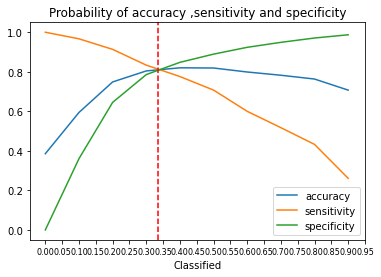

In [306]:
optimization_df.plot.line(x='Classified', y=['accuracy','sensitivity','specificity'])
plt.title('Probability of accuracy ,sensitivity and specificity')
plt.xticks(np.arange(0,1,step=0.05),size=8)
plt.axvline(x=0.335, color='r', linestyle='--') # additing axline
plt.show()

In [307]:
optimization_df

,Classified,accuracy,sensitivity,specificity
0.0,0.0,0.385591,1.000000,0.000000
0.1,0.1,0.594310,0.966720,0.360594
0.2,0.2,0.748609,0.913392,0.645194
0.3,0.3,0.804267,0.833601,0.785858
0.4,0.4,0.820037,0.775862,0.847760
0.5,0.5,0.819109,0.707298,0.889280
0.6,0.6,0.798856,0.599840,0.923754
0.7,0.7,0.782468,0.517241,0.948918
0.8,0.8,0.763296,0.432638,0.970810
0.9,0.9,0.707174,0.261026,0.987167


#### 0.4 seems to be the optimal cut off.

In [308]:
label_train_pred_df['Classified'] = label_train_pred_df.Predicted.map(lambda d: 1 if d > 0.4 else 0)
confusion_matrix = metrics.confusion_matrix(label_train_pred_df.Converted, label_train_pred_df.Classified)
model_performance_check(confusion_matrix)

Model Accuracy value is              :  82.0 %
Model Sensitivity value is           :  77.59 %
Model Specificity value is           :  84.78 %
Model Precision value is             :  76.18 %
Model Recall value is                :  77.59 %
Model True Positive Rate (TPR)       :  77.59 %
Model False Positive Rate (FPR)      :  15.22 %
Model Poitive Prediction Value is    :  76.18 %
Model Negative Prediction value is   :  85.77 %


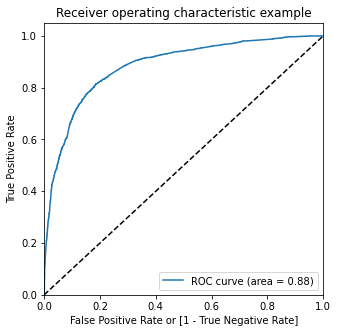

In [309]:
fpr, tpr, thresholds = metrics.roc_curve(label_train_pred_df.Converted, label_train_pred_df.Predicted,
                                              drop_intermediate = False)
auc_score = metrics.roc_auc_score(label_train_pred_df.Converted, label_train_pred_df.Predicted)
plt.figure(figsize=(5, 5))
plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

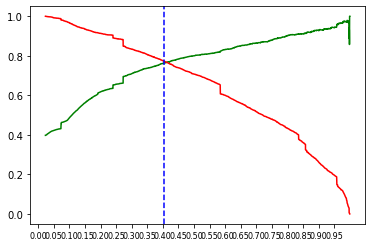

In [310]:
#Precision and recall tradeoff
p, r, thresholds = precision_recall_curve(label_train_pred_df.Converted, label_train_pred_df.Predicted)
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.xticks(np.arange(0,1,step=0.05),size=8)
plt.axvline(x=0.404, color='b', linestyle='--') # additing axline
plt.show()

#### Precision recall trade-off also giving cut-off point as 0.4. 

## Model Prediction

In [311]:
# Scaling the test data
test_df[numerical_columns] = scaler.transform(test_df[numerical_columns])
test_df.head()

,Converted,Total Time Spent on Website,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Direct Traffic,Lead Source_Facebook,Lead Source_Google,Lead Source_Live Chat,Lead Source_NC_EDM,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Pay per Click Ads,Lead Source_Press_Release,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Social Media,Lead Source_WeLearn,Lead Source_Welingak Website,Lead Source_bing,Lead Source_blog,Lead Source_google,Lead Source_testone,Lead Source_welearnblog_Home,Lead Source_youtubechannel,Do Not Email_Yes,Last Activity_Converted to Lead,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Marked Spam,Last Activity_Email Opened,Last Activity_Email Received,Last Activity_Form Submitted on Website,Last Activity_Had a Phone Conversation,Last Activity_Olark Chat Conversation,Last Activity_Page Visited on Website,Last Activity_Resubscribed to emails,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Last Activity_View in browser link Clicked,Last Activity_Visited Booth in Tradeshow,Country_Australia,Country_Bahrain,Country_Bangladesh,Country_Belgium,Country_Canada,Country_China,Country_Denmark,...,Country_Germany,Country_Ghana,Country_Hong Kong,Country_India,Country_Indonesia,Country_Italy,Country_Kenya,Country_Kuwait,Country_Liberia,Country_Malaysia,Country_Netherlands,Country_Nigeria,Country_Oman,Country_Philippines,Country_Qatar,Country_Russia,Country_Saudi Arabia,Country_Singapore,Country_South Africa,Country_Sri Lanka,Country_Sweden,Country_Switzerland,Country_Tanzania,Country_Uganda,Country_United Arab Emirates,Country_United Kingdom,Country_United States,Country_Vietnam,Country_unknown,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional,A free copy of Mastering The Interview_Yes,Last Notable Activity_Email Bounced,Last Notable Activity_Email Link Clicked,Last Notable Activity_Email Marked Spam,Last Notable Activity_Email Opened,Last Notable Activity_Email Received,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
8087,1,-0.896237,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5177,0,0.574699,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1148,1,-0.592536,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
7291,1,-0.799272,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1979,1,2.078566,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [312]:
#adding contant value
test_df_sm = sm.add_constant(test_df[rfe_feature_list])
test_df_sm.columns

Index(['const', 'Total Time Spent on Website', 'Lead Origin_Lead Add Form',
       'Lead Source_Olark Chat', 'Do Not Email_Yes',
       'Last Activity_Converted to Lead', 'Last Activity_Email Bounced',
       'Last Activity_Olark Chat Conversation',
       'Last Activity_Page Visited on Website',
       'What is your current occupation_Working Professional',
       'Last Notable Activity_Email Link Clicked',
       'Last Notable Activity_Email Opened', 'Last Notable Activity_Modified',
       'Last Notable Activity_Olark Chat Conversation'],
      dtype='object')

In [313]:
test_pred = log_model.predict(test_df_sm)

In [314]:
test_pred_df = pd.concat([test_df[[label]], pd.DataFrame(test_pred)],axis=1)

In [315]:
test_pred_df = test_pred_df.rename(columns={ 0 : 'Predicted'})
test_pred_df

,Converted,Predicted
8087,1,0.990541
5177,0,0.375114
1148,1,0.043688
7291,1,0.300885
1979,1,0.922555
...,...,...
5777,1,0.320746
3663,0,0.072815
523,0,0.677102
7346,1,0.741684


In [316]:
test_pred_df['Classified'] = test_pred_df.Predicted.map(lambda d: 1 if d > 0.4 else 0)

test_pred_df.head()

,Converted,Predicted,Classified
8087,1,0.990541,1
5177,0,0.375114,0
1148,1,0.043688,0
7291,1,0.300885,0
1979,1,0.922555,1


In [317]:
confusion_matrix = metrics.confusion_matrix(test_pred_df.Converted, test_pred_df.Classified)
model_performance_check(confusion_matrix)

Model Accuracy value is              :  81.1 %
Model Sensitivity value is           :  76.48 %
Model Specificity value is           :  83.99 %
Model Precision value is             :  74.93 %
Model Recall value is                :  76.48 %
Model True Positive Rate (TPR)       :  76.48 %
Model False Positive Rate (FPR)      :  16.01 %
Model Poitive Prediction Value is    :  74.93 %
Model Negative Prediction value is   :  85.09 %


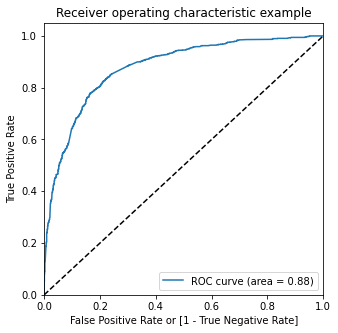

In [318]:
fpr, tpr, thresholds = metrics.roc_curve(test_pred_df.Converted, test_pred_df.Predicted,
                                              drop_intermediate = False)
auc_score = metrics.roc_auc_score(test_pred_df.Converted, test_pred_df.Predicted)
plt.figure(figsize=(5, 5))
plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Lead Score

In [319]:
test_pred_df['score']=(test_pred_df['Predicted']*100)
test_pred_df.sort_values(by='score',ascending=False)
test_pred_df

,Converted,Predicted,Classified,score
8087,1,0.990541,1,99.054127
5177,0,0.375114,0,37.511364
1148,1,0.043688,0,4.368835
7291,1,0.300885,0,30.088451
1979,1,0.922555,1,92.255519
...,...,...,...,...
5777,1,0.320746,0,32.074588
3663,0,0.072815,0,7.281535
523,0,0.677102,1,67.710209
7346,1,0.741684,1,74.168378
